# Forecasting Closing Price Using LSTMs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (15,3)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zl89sboh because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
class seq2seq_lstm(tf.keras.Model):
    def __init__(self, window, horizon, hidden_units):
        super(seq2seq_lstm, self).__init__()
        self.window = window
        self.horizon = horizon
        self.hidden_units = hidden_units
        self.encoder = tf.keras.layers.LSTM(self.hidden_units,
                                           return_sequences=False,
                                           return_state=True)
        self.decoder = tf.keras.layers.LSTM(self.hidden_units,
                                           return_sequences=False,
                                           return_state=True)
        self.dense = tf.keras.layers.Dense(1)

    def call(self, x, state=None):
        output = []
        [encoder_output, encoder_state_h,
         encoder_state_c] = self.encoder(x, initial_state=state)
        encoder_output = tf.expand_dims(encoder_output, 1)
        decoder_input = self.dense(encoder_output)
        encoder_state = [encoder_state_h, encoder_state_c]
        [decoder_output, decoder_state_h,
         decoder_state_c] = self.decoder(decoder_input,
                                         initial_state=encoder_state)
        decoder_input = self.dense(decoder_output)
        decoder_state = [decoder_state_h, decoder_state_c]
        output.append(decoder_input)

        for i in range(1, self.horizon):
            decoder_input = tf.expand_dims(decoder_input, 1) 
            [decoder_output, decoder_state_h,
             decoder_state_c] = self.decoder(decoder_input,
                                             initial_state=decoder_state)
            decoder_state = [decoder_state_h, decoder_state_c]
            decoder_input = self.dense(decoder_output)
            output.append(decoder_input)

        output = tf.stack(output)
        output = tf.transpose(output, [1, 0, 2])
        return output

In [3]:
results = []

# Tesla

In [4]:
filename = 'tesla'
df_mean = pd.read_csv('data/{}_complete.csv'.format(filename),
                      index_col=['Date'])
df_cumsum = pd.read_csv('data/{}_cumsum_completed.csv'.format(filename),
                        index_col=['Date'])

df = df_mean[['Close', 'Daily Average Tone']]
df.columns = ['Close', 'mean']
df['cumsum'] = df_cumsum.iloc[:, -1]

# train-val-test split
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# scaling
train_mean = df[:train_size].mean()
train_std = df[:train_size].std()

df_hour_norm = (df - train_mean) / train_std

# set features
target = ['Close']

for covariates in [[], ['mean'], ['cumsum']]:
    # train-val-test split
    ts = df_hour_norm[target + covariates].to_numpy()
    ts_train = ts[:train_size]
    ts_val = ts[train_size:train_size+val_size]
    ts_test = ts[train_size+val_size:]

    hs = [1, 3, 5]
    for h in hs:
        w = 10

        # Other params
        batch_size = 64
        seed = 42
        shuffle = True

        x_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # Create val iterators
        x_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        x_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # zip datasets
        train_ds = tf.data.Dataset.zip((x_train, y_train))
        val_ds = tf.data.Dataset.zip((x_val, y_val))
        test_ds = tf.data.Dataset.zip((x_test, y_test))

        hidden_units = 64
        model = seq2seq_lstm(w, h, hidden_units)

        model.compile(loss='huber',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mae'])
        epochs = 32
        history = model.fit(
            x=train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=False)

        errs_seq2seq = {'RMSE': [], 'MAE': []}
        for x_test, y_test in test_ds:
            forecast = model.predict(x_test).squeeze(-1)
            y_test = (y_test*train_std[target][0]) + train_mean[target][0]
            forecast = (forecast*train_std[target][0]) + train_mean[target][0]

            errs_seq2seq['RMSE'].append(
                np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
            errs_seq2seq['MAE'].append(
                tf.keras.metrics.mae(y_test, forecast).numpy().mean())
        errs_seq2seq['RMSE'] = np.mean(errs_seq2seq['RMSE'])
        errs_seq2seq['MAE'] = np.mean(errs_seq2seq['MAE'])
        results.append({filename: errs_seq2seq})

2022-03-14 18:40:27.717833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 18:40:28.435673: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5
2022-03-14 18:40:30.958772: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-14 18:40:32.389962: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101


# Facebook

In [5]:
filename = 'facebook'
df_mean = pd.read_csv('data/{}_completed.csv'.format(filename),
                      index_col=['Date'])
df_cumsum = pd.read_csv('data/{}_cumsum_completed.csv'.format(filename),
                        index_col=['Date'])

df = df_mean[['Close', 'Daily Average Tone']]
df.columns = ['Close', 'mean']
df['cumsum'] = df_cumsum.iloc[:, -1]

# train-val-test split
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# scaling
train_mean = df[:train_size].mean()
train_std = df[:train_size].std()

df_hour_norm = (df - train_mean) / train_std

# set features
target = ['Close']

for covariates in [[], ['mean'], ['cumsum']]:
    # train-val-test split
    ts = df_hour_norm[target + covariates].to_numpy()
    ts_train = ts[:train_size]
    ts_val = ts[train_size:train_size+val_size]
    ts_test = ts[train_size+val_size:]

    hs = [1, 3, 5]
    for h in hs:
        w = 10

        # Other params
        batch_size = 64
        seed = 42
        shuffle = True

        x_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # Create val iterators
        x_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        x_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # zip datasets
        train_ds = tf.data.Dataset.zip((x_train, y_train))
        val_ds = tf.data.Dataset.zip((x_val, y_val))
        test_ds = tf.data.Dataset.zip((x_test, y_test))

        hidden_units = 64
        model = seq2seq_lstm(w, h, hidden_units)

        model.compile(loss='huber',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mae'])
        epochs = 32
        history = model.fit(
            x=train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=False)

        errs_seq2seq = {'RMSE': [], 'MAE': []}
        for x_test, y_test in test_ds:
            forecast = model.predict(x_test).squeeze(-1)
            y_test = (y_test*train_std[target][0]) + train_mean[target][0]
            forecast = (forecast*train_std[target][0]) + train_mean[target][0]

            errs_seq2seq['RMSE'].append(
                np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
            errs_seq2seq['MAE'].append(
                tf.keras.metrics.mae(y_test, forecast).numpy().mean())
        errs_seq2seq['RMSE'] = np.mean(errs_seq2seq['RMSE'])
        errs_seq2seq['MAE'] = np.mean(errs_seq2seq['MAE'])
        results.append({filename: errs_seq2seq})

# Netflix

In [6]:
filename = 'netflix'
df_mean = pd.read_csv('data/{}_completed.csv'.format(filename),
                      index_col=['Date'])
df_cumsum = pd.read_csv('data/{}_cumsum_completed.csv'.format(filename),
                        index_col=['Date'])

df = df_mean[['Close', 'Daily Average Tone']]
df.columns = ['Close', 'mean']
df['cumsum'] = df_cumsum.iloc[:, -1]

# train-val-test split
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# scaling
train_mean = df[:train_size].mean()
train_std = df[:train_size].std()

df_hour_norm = (df - train_mean) / train_std

# set features
target = ['Close']

for covariates in [[], ['mean'], ['cumsum']]:
    # train-val-test split
    ts = df_hour_norm[target + covariates].to_numpy()
    ts_train = ts[:train_size]
    ts_val = ts[train_size:train_size+val_size]
    ts_test = ts[train_size+val_size:]

    hs = [1, 3, 5]
    for h in hs:
        w = 10

        # Other params
        batch_size = 64
        seed = 42
        shuffle = True

        x_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # Create val iterators
        x_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        x_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # zip datasets
        train_ds = tf.data.Dataset.zip((x_train, y_train))
        val_ds = tf.data.Dataset.zip((x_val, y_val))
        test_ds = tf.data.Dataset.zip((x_test, y_test))

        hidden_units = 64
        model = seq2seq_lstm(w, h, hidden_units)

        model.compile(loss='huber',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mae'])
        epochs = 32
        history = model.fit(
            x=train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=False)

        errs_seq2seq = {'RMSE': [], 'MAE': []}
        for x_test, y_test in test_ds:
            forecast = model.predict(x_test).squeeze(-1)
            y_test = (y_test*train_std[target][0]) + train_mean[target][0]
            forecast = (forecast*train_std[target][0]) + train_mean[target][0]

            errs_seq2seq['RMSE'].append(
                np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
            errs_seq2seq['MAE'].append(
                tf.keras.metrics.mae(y_test, forecast).numpy().mean())
        errs_seq2seq['RMSE'] = np.mean(errs_seq2seq['RMSE'])
        errs_seq2seq['MAE'] = np.mean(errs_seq2seq['MAE'])
        results.append({filename: errs_seq2seq})

# Amazon

In [7]:
filename = 'amazon'
df_mean = pd.read_csv('data/{}_completed.csv'.format(filename),
                      index_col=['Date'])
df_cumsum = pd.read_csv('data/{}_cumsum_completed.csv'.format(filename),
                        index_col=['Date'])

df = df_mean[['Close', 'Daily Average Tone']]
df.columns = ['Close', 'mean']
df['cumsum'] = df_cumsum.iloc[:, -1]

# train-val-test split
train_size = int(0.7 * len(df))
val_size = int(0.2 * len(df))
test_size = len(df) - train_size - val_size

# scaling
train_mean = df[:train_size].mean()
train_std = df[:train_size].std()

df_hour_norm = (df - train_mean) / train_std

# set features
target = ['Close']

for covariates in [[], ['mean'], ['cumsum']]:
    # train-val-test split
    ts = df_hour_norm[target + covariates].to_numpy()
    ts_train = ts[:train_size]
    ts_val = ts[train_size:train_size+val_size]
    ts_test = ts[train_size+val_size:]

    hs = [1, 3, 5]
    for h in hs:
        w = 10

        # Other params
        batch_size = 64
        seed = 42
        shuffle = True

        x_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_train = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_train[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # Create val iterators
        x_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_val = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_val[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        x_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[:-h, :],
            targets=None,
            sequence_length=w,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        y_test = tf.keras.utils.timeseries_dataset_from_array(
            data=ts_test[w:, 0],
            targets=None,
            sequence_length=h,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed
        )

        # zip datasets
        train_ds = tf.data.Dataset.zip((x_train, y_train))
        val_ds = tf.data.Dataset.zip((x_val, y_val))
        test_ds = tf.data.Dataset.zip((x_test, y_test))

        hidden_units = 64
        model = seq2seq_lstm(w, h, hidden_units)

        model.compile(loss='huber',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      metrics=['mae'])
        epochs = 32
        history = model.fit(
            x=train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=False)

        errs_seq2seq = {'RMSE': [], 'MAE': []}
        for x_test, y_test in test_ds:
            forecast = model.predict(x_test).squeeze(-1)
            y_test = (y_test*train_std[target][0]) + train_mean[target][0]
            forecast = (forecast*train_std[target][0]) + train_mean[target][0]

            errs_seq2seq['RMSE'].append(
                np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
            errs_seq2seq['MAE'].append(
                tf.keras.metrics.mae(y_test, forecast).numpy().mean())
        errs_seq2seq['RMSE'] = np.mean(errs_seq2seq['RMSE'])
        errs_seq2seq['MAE'] = np.mean(errs_seq2seq['MAE'])
        results.append({filename: errs_seq2seq})

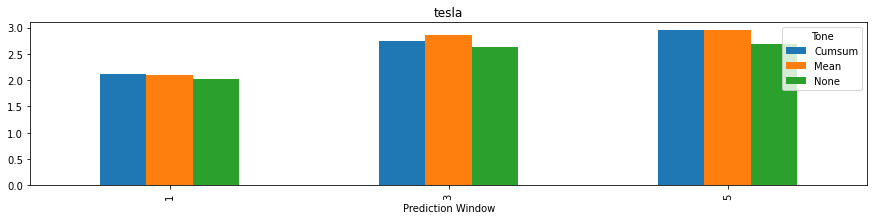

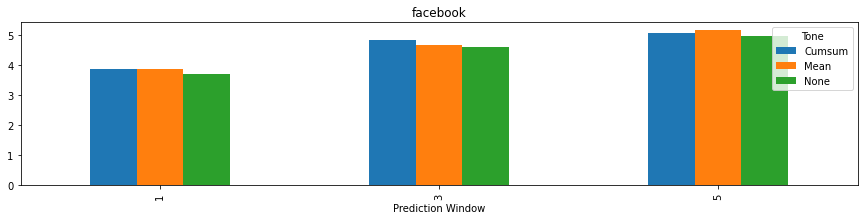

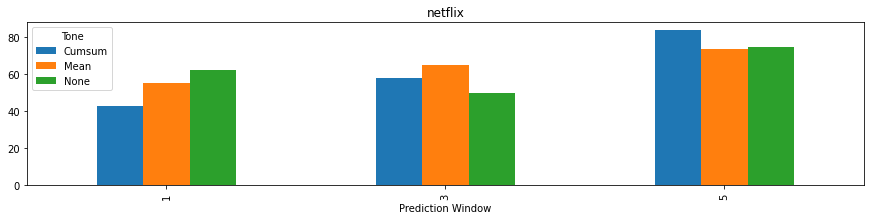

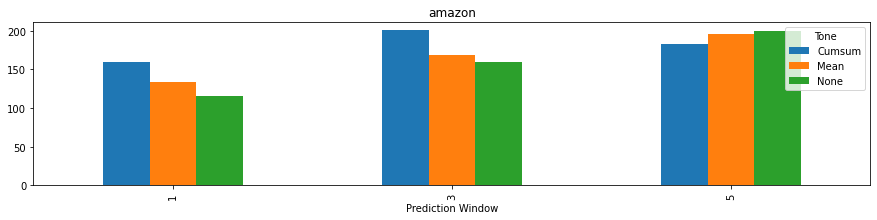

In [59]:
res = []
for i in ['tesla', 'facebook', 'netflix', 'amazon']:
    for j in ['None', 'Mean', 'Cumsum']:
        for k in [1, 3, 5]:
            res.append([i, j, k])
res = pd.DataFrame(res, columns=['stock', 'Tone', 'Prediction Window'])
res['MAE'] = [list(i.values())[0]['MAE'] for i in results]

for i in ['tesla', 'facebook', 'netflix', 'amazon']:
    res[res['stock'] == i].pivot("Prediction Window", "Tone", "MAE").plot(kind='bar')
    plt.title(i)
    plt.show()